   Author: Ankit Kariryaa, University of Bremen

### Getting started
Define the paths to the dataset and trained models in the `notebooks/config/UNetTraining.py` file.  

In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
!conda env list

# conda environments:
#
base                     /mnt/home/parakhni/anaconda3
p39                      /mnt/home/parakhni/anaconda3/envs/p39
p392                  *  /mnt/home/parakhni/anaconda3/envs/p392



In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import json
from sklearnex.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)

2022-03-28 23:29:35.292003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-28 23:29:36.948114: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-28 23:29:36.949210: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-28 23:29:37.290506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-28 23:29:37.291229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2022-03-28 23:29:38.018619: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 23:29:38.023531: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-28 23:29:38.530358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-28 23:29:38.530791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GH

2.4.1


In [4]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/UNetTraining.py)
# Please provide required info in the file before continuing with this notebook. 
 
from configTemplate import UNetTraining
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import UNetTraining
config = UNetTraining.Configuration()

In [5]:
# Read all images/frames into memory
frames = []

all_files = os.listdir(config.base_dir)
all_files_ndvi = [fn for fn in all_files if fn.startswith(config.ndvi_fn) and fn.endswith(config.image_type)]
len(all_files_ndvi)
print(all_files_ndvi)
for i, fn in enumerate(all_files_ndvi):
    ndvi_img = rasterio.open(os.path.join(config.base_dir, fn))
    pan_img = rasterio.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.pan_fn)))
    read_ndvi_img = ndvi_img.read()
    read_pan_img = pan_img.read()
    comb_img = np.concatenate((read_ndvi_img, read_pan_img), axis=0)
    comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
    annotation_im = Image.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.annotation_fn)))
    annotation = np.array(annotation_im)
    weight_im = Image.open(os.path.join(config.base_dir, fn.replace(config.ndvi_fn,config.weight_fn)))
    weight = np.array(weight_im)
    f = FrameInfo(comb_img, annotation, weight)
    frames.append(f)

3

['ndvi_0.png', 'ndvi_2.png', 'ndvi_1.png']


In [6]:
training_frames, validation_frames, testing_frames  = split_dataset(frames, config.frames_json, config.patch_dir)
# training_frames = validation_frames = testing_frames  = list(range(len(frames)))
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    annotation_channels = config.input_label_channel + config.input_weight_channel
    train_generator = DataGenerator(config.input_image_channel, config.patch_size, training_frames, frames, annotation_channels, augmenter = 'iaa').random_generator(config.BATCH_SIZE, normalize = config.normalize)
    val_generator = DataGenerator(config.input_image_channel, config.patch_size, validation_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)
    test_generator = DataGenerator(config.input_image_channel, config.patch_size, testing_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)

Reading train-test split from file
training_frames [2]
validation_frames [0]
testing_frames [1]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


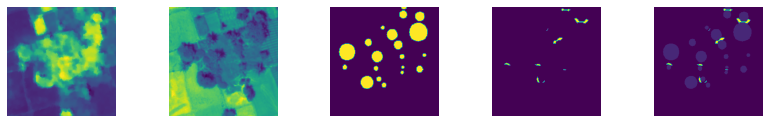

In [7]:
for _ in range(1):
    train_images, real_label = next(train_generator)
    ann = real_label[:,:,:,0]
    wei = real_label[:,:,:,1]
    #overlay of annotation with boundary to check the accuracy
    #5 images in each row are: pan, ndvi, annotation, weight(boundary), overlay of annotation with weight
    overlay = ann + wei
    overlay = overlay[:,:,:,np.newaxis]
    display_images(np.concatenate((train_images,real_label, overlay), axis = -1))

In [8]:


#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'trees_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [9]:
# Define the model and compile it
with mirrored_strategy.scope():
    OPTIMIZER = adaDelta
    LOSS = tversky 
    model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy', factor=0.33,
                                   patience=4, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

2022-03-28 23:29:44.693676: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-03-28 23:29:44.693701: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-03-28 23:29:44.693727: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 4 GPUs
2022-03-28 23:29:44.695251: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-03-28 23:29:45.279391: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-03-28 23:29:45.279511: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [11]:
with mirrored_strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    
    dataset = tf.data.Dataset.from_generator(lambda: map(tuple, train_generator), output_signature=(tf.TensorSpec(shape=(config.BATCH_SIZE, 256, 256, 2), dtype=tf.float32), tf.TensorSpec(shape=(config.BATCH_SIZE, 256, 256, 2), dtype=tf.float32)))
    validate = tf.data.Dataset.from_generator(lambda: map(tuple, val_generator), output_signature=(tf.TensorSpec(shape=(config.BATCH_SIZE, 256, 256, 2), dtype=tf.float32), tf.TensorSpec(shape=(config.BATCH_SIZE, 256, 256, 2), dtype=tf.float32)))
    test_data = tf.data.Dataset.from_generator(lambda: map(tuple, test_generator), output_signature=(tf.TensorSpec(shape=(config.BATCH_SIZE, 256, 256, 2), dtype=tf.float32), tf.TensorSpec(shape=(config.BATCH_SIZE, 256, 256, 2), dtype=tf.float32)))


In [12]:
# dataset = dataset.with_options(options)
# validate = dataset.with_options(validate)
# test_data = dataset.with_options(test_data)


In [13]:
loss_history = [model.fit(dataset.prefetch(tf.data.AUTOTUNE), 
                         steps_per_epoch=config.MAX_TRAIN_STEPS, 
                         epochs=config.NB_EPOCHS, 
                         validation_data=validate.prefetch(tf.data.AUTOTUNE),
                         validation_steps=config.VALID_IMG_COUNT,
                         callbacks=callbacks_list,
                         verbose=1,
                         workers=200,
                         use_multiprocessing=True # the generator is not very thread safe
                        )]

2022-03-28 23:29:45.616783: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2510"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 2
        }
      }
      shape {
        dim {
          size: 1
        }
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 2
        }
      }
  

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:batch_all_reduce: 54 all-reduces with algorithm = nccl, num_packs = 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Pl

2022-03-28 23:29:59.707150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-28 23:30:01.290411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


   2/1000 [..............................] - ETA: 10:00 - loss: 0.8257 - dice_coef: 0.0934 - dice_loss: 0.9066 - specificity: nan - sensitivity: nan - accuracy: 0.3661  

2022-03-28 23:30:02.739679: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-03-28 23:30:02.739715: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


   5/1000 [..............................] - ETA: 4:57 - loss: 0.8177 - dice_coef: 0.0822 - dice_loss: 0.9178 - specificity: nan - sensitivity: nan - accuracy: 0.4744

2022-03-28 23:30:02.823141: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-03-28 23:30:02.827636: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2022-03-28 23:30:02.848754: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 1665 callback api events and 1634 activity events. 
2022-03-28 23:30:02.958250: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-03-28 23:30:03.023874: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/UNet_20220328-2329_AdaDelta_weightmap_tversky_012_256/train/plugins/profile/2022_03_28_23_30_02
2022-03-28 23:30:03.080044: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/UNet_20220328-2329_AdaDelta_weightmap_tversky_012_256/train/plugins/profile/2022_03_28_23_30_02/nvf-000.trace.json.gz
2022-03-28 23:

1000/1000 [==============================] - ETA: 0s - loss: 0.5212 - dice_coef: 0.3756 - dice_loss: 0.6244 - specificity: nan - sensitivity: nan - accuracy: 0.9002

2022-03-28 23:31:08.058073: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2535"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 2
        }
      }
      shape {
        dim {
          size: 1
        }
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 2
        }
      }
  

1000/1000 [==============================] - 88s 72ms/step - loss: 0.5211 - dice_coef: 0.3758 - dice_loss: 0.6242 - specificity: nan - sensitivity: nan - accuracy: 0.9002 - val_loss: 0.4542 - val_dice_coef: 0.8107 - val_dice_loss: 0.1893 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.8921

Epoch 00001: val_accuracy improved from -inf to 0.89213, saving model to ./saved_models/UNet/trees_20220328-2329_AdaDelta_weightmap_tversky_012_256.h5
Epoch 2/100
1000/1000 [==============================] - 66s 66ms/step - loss: 0.2531 - dice_coef: 0.8895 - dice_loss: 0.1105 - specificity: nan - sensitivity: nan - accuracy: 0.9563 - val_loss: 0.4837 - val_dice_coef: 0.8413 - val_dice_loss: 0.1587 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.8993

Epoch 00002: val_accuracy improved from 0.89213 to 0.89926, saving model to ./saved_models/UNet/trees_20220328-2329_AdaDelta_weightmap_tversky_012_256.h5
Epoch 3/100
1000/1000 [==============================] - 66s 66ms/s

1000/1000 [==============================] - 66s 66ms/step - loss: 0.1103 - dice_coef: 0.9226 - dice_loss: 0.0774 - specificity: nan - sensitivity: nan - accuracy: 0.9855 - val_loss: 0.3706 - val_dice_coef: 0.8890 - val_dice_loss: 0.1110 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9088

Epoch 00021: val_accuracy did not improve from 0.91375
Epoch 22/100
1000/1000 [==============================] - 65s 65ms/step - loss: 0.1042 - dice_coef: 0.9282 - dice_loss: 0.0718 - specificity: nan - sensitivity: nan - accuracy: 0.9855 - val_loss: 0.4013 - val_dice_coef: 0.8896 - val_dice_loss: 0.1104 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9095

Epoch 00022: val_accuracy did not improve from 0.91375
Epoch 23/100
1000/1000 [==============================] - 65s 65ms/step - loss: 0.1025 - dice_coef: 0.9257 - dice_loss: 0.0743 - specificity: nan - sensitivity: nan - accuracy: 0.9863 - val_loss: 0.3949 - val_dice_coef: 0.8917 - val_dice_loss: 0.1083 - val_spec

1000/1000 [==============================] - 65s 65ms/step - loss: 0.1104 - dice_coef: 0.9589 - dice_loss: 0.0411 - specificity: nan - sensitivity: nan - accuracy: 0.9867 - val_loss: 0.3941 - val_dice_coef: 0.8965 - val_dice_loss: 0.1035 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9088

Epoch 00042: val_accuracy did not improve from 0.91473
Epoch 43/100
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0931 - dice_coef: 0.9604 - dice_loss: 0.0396 - specificity: nan - sensitivity: nan - accuracy: 0.9883 - val_loss: 0.4016 - val_dice_coef: 0.8934 - val_dice_loss: 0.1066 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9055

Epoch 00043: val_accuracy did not improve from 0.91473
Epoch 44/100
1000/1000 [==============================] - 65s 65ms/step - loss: 0.1083 - dice_coef: 0.9579 - dice_loss: 0.0421 - specificity: nan - sensitivity: nan - accuracy: 0.9861 - val_loss: 0.4169 - val_dice_coef: 0.8954 - val_dice_loss: 0.1046 - val_spec


Epoch 00063: val_accuracy did not improve from 0.91473
Epoch 64/100
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0842 - dice_coef: 0.9767 - dice_loss: 0.0233 - specificity: nan - sensitivity: nan - accuracy: 0.9888 - val_loss: 0.3883 - val_dice_coef: 0.9015 - val_dice_loss: 0.0985 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9090

Epoch 00064: val_accuracy did not improve from 0.91473
Epoch 65/100
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0913 - dice_coef: 0.9778 - dice_loss: 0.0222 - specificity: nan - sensitivity: nan - accuracy: 0.9881 - val_loss: 0.3869 - val_dice_coef: 0.9047 - val_dice_loss: 0.0953 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9129

Epoch 00065: val_accuracy did not improve from 0.91473
Epoch 66/100
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0966 - dice_coef: 0.9767 - dice_loss: 0.0233 - specificity: nan - sensitivity: nan - accuracy: 0.9878 - val_lo


Epoch 00085: val_accuracy did not improve from 0.91473
Epoch 86/100
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0745 - dice_coef: 0.9818 - dice_loss: 0.0182 - specificity: nan - sensitivity: nan - accuracy: 0.9903 - val_loss: 0.3985 - val_dice_coef: 0.9007 - val_dice_loss: 0.0993 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9077

Epoch 00086: val_accuracy did not improve from 0.91473
Epoch 87/100
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0873 - dice_coef: 0.9808 - dice_loss: 0.0192 - specificity: nan - sensitivity: nan - accuracy: 0.9893 - val_loss: 0.4066 - val_dice_coef: 0.9029 - val_dice_loss: 0.0971 - val_specificity: nan - val_sensitivity: nan - val_accuracy: 0.9097

Epoch 00087: val_accuracy did not improve from 0.91473
Epoch 88/100
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0944 - dice_coef: 0.9812 - dice_loss: 0.0188 - specificity: nan - sensitivity: nan - accuracy: 0.9886 - val_lo

2022-03-29 01:19:18.658857: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_798592"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

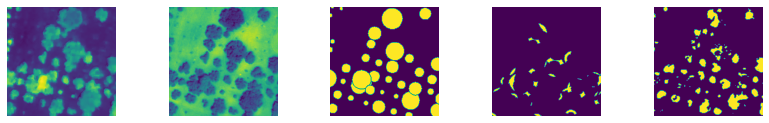

In [14]:
# Print one batch on the training/test data!
for i in range(1):
    test_images, real_label = next(test_generator)
    #5 images per row: pan, ndvi, label, weight, prediction
    prediction = model.predict(test_images, steps=1)
    prediction[prediction>0.5]=1
    prediction[prediction<=0.5]=0
    display_images(np.concatenate((test_images, real_label, prediction), axis = -1))